## Importações

In [5]:
%env TF_CPP_MIN_LOG_LEVEL = 3

env: TF_CPP_MIN_LOG_LEVEL=3


In [57]:
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import nltk
from nltk.translate.bleu_score import corpus_bleu
import warnings
warnings.filterwarnings('ignore')

## Organizando as Imagens em Disco

In [7]:
BASE_DIR = 'dados'
WORKING_DIR = 'processamento'

## Carregando o Modelo Pré-Treinado

In [8]:
modelo_vgg = VGG16()

I0000 00:00:1723410357.568602    5125 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723410357.740162    5125 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723410357.740380    5125 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723410357.741867    5125 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [9]:
modelo = Model(inputs = modelo_vgg.inputs, outputs = modelo_vgg.layers[-2].output)

In [10]:
modelo.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

## Extrator de Recursos para Pŕe-Processamento de Imagens

In [8]:
atributos = {}

In [9]:
diretorio = os.path.join(BASE_DIR, 'Images')

In [14]:
%%time

for img_name in tqdm(os.listdir(diretorio)):
    img_path = os.path.join(diretorio, img_name)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    atributo = modelo.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    atributos[image_id] = atributo

  0%|                                                                                                                                                                                     | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1723329207.822390   14057 service.cc:146] XLA service 0x7be74c005680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723329207.822430   14057 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
I0000 00:00:1723329209.935566   14057 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8091/8091 [06:33<00:00, 20.58it/s]

CPU times: user 6min 29s, sys: 19.4 s, total: 6min 48s
Wall time: 6min 33s


In [16]:
pickle.dump(atributos, open(os.path.join(WORKING_DIR, 'atributos.pkl'), 'wb'))

In [11]:
with open(os.path.join(WORKING_DIR, 'atributos.pkl'), 'rb') as f:
    atributos = pickle.load(f)

In [12]:
atributos['3585117340_73e96b6173']

array([[1.9417957, 0.       , 3.718985 , ..., 0.       , 1.9535811,
        0.       ]], dtype=float32)

## Pré-Processamento dos Dados de Texto

In [13]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [14]:
mapping = {}

In [15]:
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue

    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]

    caption = " ".join(caption)
    
    if image_id not in mapping:
        mapping[image_id] = []

    mapping[image_id].append(caption)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40456/40456 [00:00<00:00, 1042424.16it/s]


In [16]:
len(mapping)

8091

In [17]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):

            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'

            captions[i] = caption

In [18]:
clean(mapping)

In [19]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [20]:
all_captions = []

In [21]:
for key in mapping:
    for caption in mapping[key]:

        all_captions.append(caption)

In [22]:
len(all_captions)

40455

## Processo de Tokenização

In [23]:
tokenizer = Tokenizer()

In [24]:
tokenizer.fit_on_texts(all_captions)

In [25]:
vocab_size = len(tokenizer.word_index) + 1

In [26]:
vocab_size

8485

In [27]:
max_length = max(len(caption.split()) for caption in all_captions)

In [28]:
max_length

35

## Divisão dos Dados (Preparação dos Dados Para Treinamento)

In [29]:
image_ids = list(mapping.keys())

In [30]:
split = int(len(image_ids) * .90)

In [31]:
dados_treino = image_ids[:split]
dados_teste = image_ids[split:]

In [32]:
def data_generator(data_keys, mapping, atributos, tokenizer, max_length, vocab_size, batch_size):
    x1, x2, y = [], [], []
    n = 0

    while 1:

        for key in data_keys:
            n += 1
            captions = mapping[key]

            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):

                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen = max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes= vocab_size)[0]

                    x1.append(atributos[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:

                x1, x2, y = np.array(x1), np.array(x2), np.array(y)
                yield (x1, x2), y

                x1, x2, y = [], [], []
                n = 0

## Arquitetura do Modelo

In [33]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

In [34]:
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

In [35]:
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

In [36]:
modelo_final = Model(inputs=[inputs1, inputs2], outputs=outputs)
modelo_final.compile(loss='categorical_crossentropy', optimizer='adam')

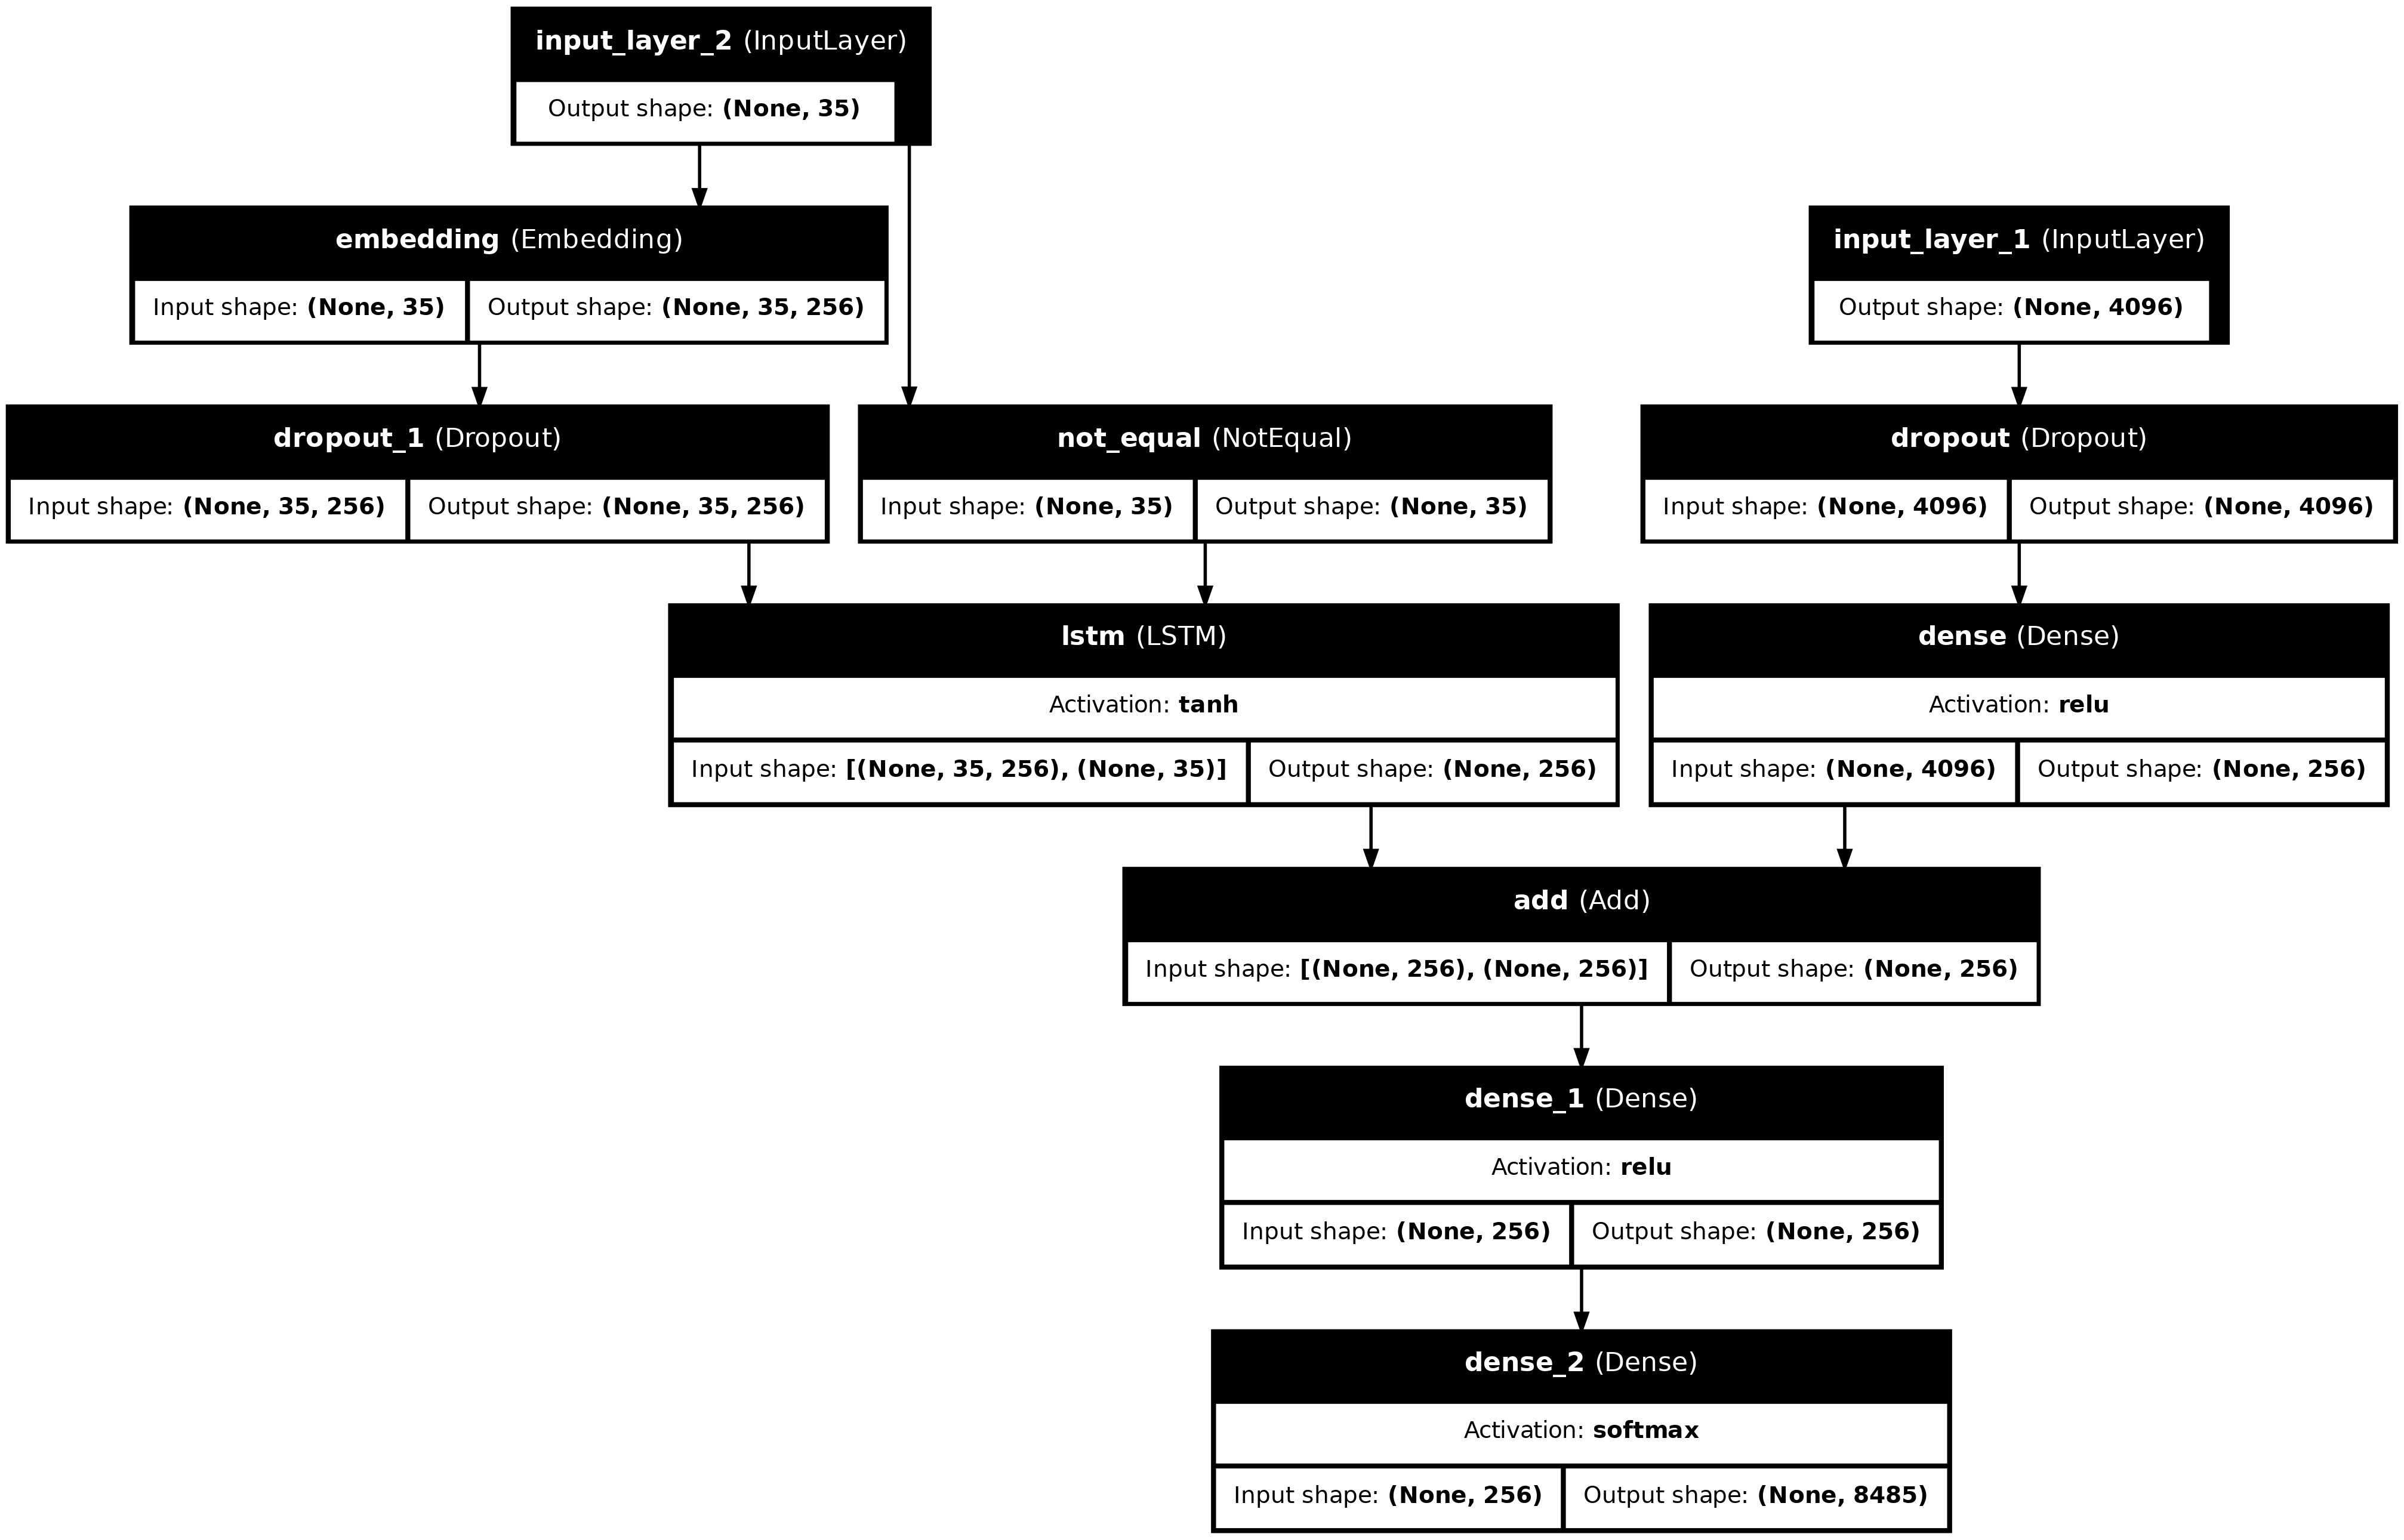

In [37]:
plot_model(modelo_final, show_shapes= True, show_layer_names= True, show_layer_activations= True)

## Treinamento do Modelo

In [38]:
epochs = 25
batch_size = 32
steps = len(dados_treino) // batch_size

In [39]:
%%time

for i in range(epochs):
    
    # Cria o gerador de dados
    generator = data_generator(dados_treino, 
                                   mapping, 
                                   atributos, 
                                   tokenizer, 
                                   max_length, 
                                   vocab_size, 
                                   batch_size)
    
    # Treinamento do modelo
    modelo_final.fit(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - loss: 5.7702
227/227 ━━━━━━━━━━━━━━━━━━━━ 28s 125ms/step - loss: 4.0583
227/227 ━━━━━━━━━━━━━━━━━━━━ 28s 124ms/step - loss: 3.5839
227/227 ━━━━━━━━━━━━━━━━━━━━ 28s 124ms/step - loss: 3.3053
227/227 ━━━━━━━━━━━━━━━━━━━━ 28s 125ms/step - loss: 3.0995
227/227 ━━━━━━━━━━━━━━━━━━━━ 28s 124ms/step - loss: 2.9502
227/227 ━━━━━━━━━━━━━━━━━━━━ 28s 124ms/step - loss: 2.8345
227/227 ━━━━━━━━━━━━━━━━━━━━ 28s 125ms/step - loss: 2.7345
227/227 ━━━━━━━━━━━━━━━━━━━━ 28s 125ms/step - loss: 2.6558
227/227 ━━━━━━━━━━━━━━━━━━━━ 28s 124ms/step - loss: 2.5813
227/227 ━━━━━━━━━━━━━━━━━━━━ 29s 128ms/step - loss: 2.5238
227/227 ━━━━━━━━━━━━━━━━━━━━ 29s 127ms/step - loss: 2.4634
227/227 ━━━━━━━━━━━━━━━━━━━━ 30s 130ms/step - loss: 2.4120
227/227 ━━━━━━━━━━━━━━━━━━━━ 29s 127ms/step - loss: 2.3620
227/227 ━━━━━━━━━━━━━━━━━━━━ 29s 127ms/step - loss: 2.3205
227/227 ━━━━━━━━━━━━━━━━━━━━ 29s 127ms/step - loss: 2.2880
227/227 ━━━━━━━━━━━━━━━━━━━━ 29s 128ms/step - loss: 2.25

In [41]:
modelo_final.save(WORKING_DIR + '/modelo_final.keras')

## Avaliação do Modelo

In [42]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [52]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'

    for i in range(max_length):

        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length, padding= 'post')
        yhat = modelo_final.predict([image, sequence], verbose= 0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)

        if word is None:
            break

        in_text += " " + word

        if word == 'endseq':
            break

    return in_text

In [53]:
actual, predicted = [], []

In [54]:
%%time

for key in tqdm(dados_teste):

    captions = mapping[key]
    y_pred = predict_caption(modelo_final, atributos[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 810/810 [05:56<00:00,  2.27it/s]

CPU times: user 5min 55s, sys: 18.7 s, total: 6min 14s
Wall time: 5min 56s


In [59]:
print(f'BLEU-1: {corpus_bleu(actual, predicted, weights= (1.0, 0, 0, 0)):.6f}')
print(f'BLEU-2: {corpus_bleu(actual, predicted, weights= (0.5, 0.5, 0, 0)):.6f}')

BLEU-1: 0.522503
BLEU-2: 0.294591


## Deploy e Uso do Modelo

In [60]:
def generate_caption(image_name):

    image_id = image_name.split('.')[0]
    image = Image.open(os.path.join(BASE_DIR, 'Images', image_name))
    y_pred = predict_caption(modelo_final, atributos[image_id], tokenizer, max_length)
    y_pred_clean = y_pred.replace('startseq', '').replace('endseq', '').strip()
    print(f'Legenda Prevista para a Imagem: {y_pred_clean}')
    plt.imshow(image)

Legenda Prevista para a Imagem: man sitting on bench


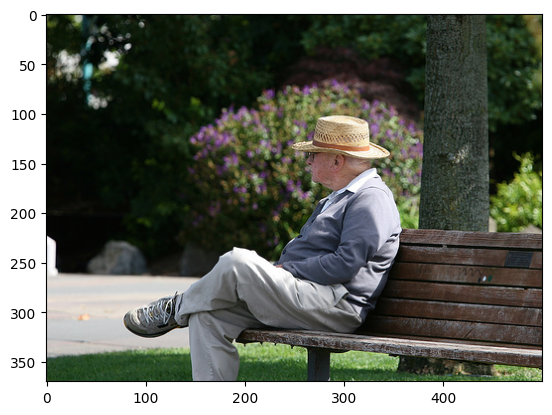

In [61]:
generate_caption('1160034462_16b38174fe.jpg')

Legenda Prevista para a Imagem: woman in brown jacket is pulling brown horse in the snow


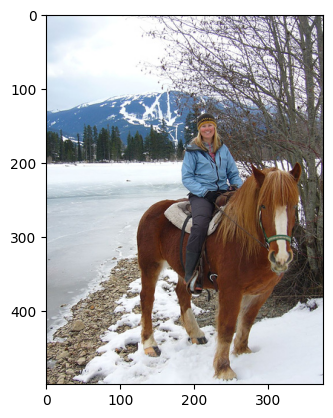

In [63]:
generate_caption('109202756_b97fcdc62c.jpg')

Legenda Prevista para a Imagem: two dogs are playing with red ball in the water


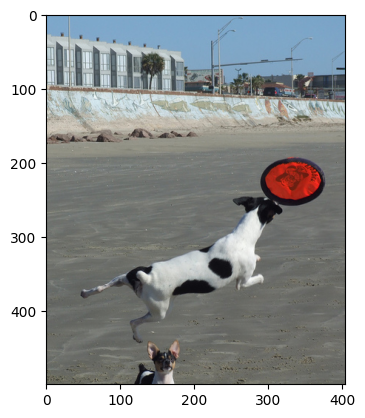

In [64]:
generate_caption('1436760519_8d6101a0ed.jpg')